In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier

# import own modules
sys.path.append("..")  # Adds higher directory to python modules path.
from scripts import features as ft
from scripts import preprocessing as pp
from scripts import evaluate_models as em

#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

import pickle

### Import full dataset

In [2]:
# path to csv file
path_df = os.path.join("..", "data", "df_deep_sam.csv")

# get features - or recalculate
recalculate_df = False
if os.path.isfile(path_df) and not recalculate_df:
    df = pd.read_csv(path_df)
else:
    df = ft.get_features()
    df.to_csv(path_df, index=False)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=['img', 'sp_idx'])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])  # drop 'object' columns

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

df = df[df["sp_fix_duration_ms_total"] <= 5000]

 -> dataframe has 7598 instances and 44 columns
 -> there are 44 numerical columns
 -> there are 0 categoricals columns


### Select features according to each model/ do train-test split

In [4]:
# define features
feat_xgb = ['sp_fix_count', 'sp_fix_duration_ms_var', 'sp_len_px_total',
       'sp_saccade_amplitude_px_mean', 'sp_saccade_amplitude_px_var',
       'sp_distance_to_centre_px_mean', 'sp_distance_to_centre_px_var',
       'sp_distance_to_sp_mean_px_mean', 'sp_distance_to_sp_mean_px_var',
       'dg_sal_first_fixation', 'dg_sal_sum', 'dg_sal_max', 'dg_sal_weighted_duration_sum',
       'dg_sal_weighted_duration_mean', 'dg_sal_KLD', 'dg_sal_NSS', 'obj_t_abs_on_face',
       'obj_t_rel_on_face', 'obj_t_abs_on_animate', 'obj_t_abs_on_inanimate',
       'obj_t_abs_on_background', 'obj_t_rel_on_animate',
       'obj_t_rel_on_inanimate', 'obj_t_rel_on_background']
       

feat_RF = ['sp_fix_count', 'sp_fix_duration_ms_total', 'sp_fix_duration_ms_mean', 
 'sp_fix_duration_ms_var', 'sp_len_px_total', 'sp_saccade_amplitude_px_mean',
 'sp_saccade_amplitude_px_var', 'sp_distance_to_centre_px_mean',
 'sp_distance_to_centre_px_var', 'sp_distance_to_sp_mean_px_mean',
 'sp_distance_to_sp_mean_px_var', 'dg_sal_first_fixation', 'dg_sal_mean',
 'dg_sal_sum', 'dg_sal_max', 'dg_sal_weighted_duration_sum',
 'dg_sal_weighted_duration_mean', 'dg_sal_KLD', 'dg_sal_NSS',
 'obj_t_abs_on_animate', 'obj_t_abs_on_background']

feat_SVC = ["sp_fix_duration_ms_total","sp_fix_duration_ms_mean","sp_fix_duration_ms_var", "sam_sal_first_fixation","sam_sal_sum","sam_sal_KLD", "obj_t_abs_on_background","obj_t_abs_on_animate", "obj_n_fix_background","obj_n_fix_inanimate","obj_n_fix_animate"]

In [5]:
# prepare features and target
X = df
y = X.pop("asd")

# define numerical columns once more
num_cols = X.columns[X.dtypes != "object"]

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6485' samples & '43' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


In [6]:
# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

### Voting predictions

In [ ]:
# List of paths to the pickle files to load
pickle_files = [
    '../models/xgb_final/xgb_final_new.pickle',
    '../models/RF_final/RF_final.pickle',
    '../models/SVC_final/best_svc_resnet.pickle'

]

# Dictionary to store loaded models
loaded_models = {}

# Load the selected pickle files
for file_path in pickle_files:
    with open(file_path, 'rb') as f:
        model_name = os.path.splitext(os.path.basename(file_path))[0]
        loaded_models[model_name] = pickle.load(f)

In [ ]:

# Dictionary to store loaded models
loaded_models = {}

# Load the selected pickle files
for file_path in pickle_files:
    with open(file_path, 'rb') as f:
        model_name = os.path.splitext(os.path.basename(file_path))[0]
        loaded_models[model_name] = pickle.load(f)

# Calibrate probabilities for each loaded model
calibrated_estimators = []
for name, model in loaded_models.items():
    calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
    # Fit the calibrated model with training data
    calibrated_model.fit(X_train, y_train)
    calibrated_estimators.append((name, calibrated_model))

# Create the voting classifier
voting_classifier = VotingClassifier(estimators=calibrated_estimators, voting='soft')

# Fit the voting classifier with training data
voting_classifier.fit(X_train, y_train)



NotFittedError: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# Create the voting classifier
voting_classifier = VotingClassifier(
    estimators=list(loaded_models.items()),
    voting='soft'  # 'soft' if models provide probabilities

)

# Fit the voting classifier
voting_classifier.fit(X_train, y_train)

# Predictions
predictions = voting_classifier.predict(X_test)

In [ ]:
# predict & proba
pred_test = voting_classifier.predict(X_test)
proba_test = voting_classifier.predict_proba(X_test)

pred_train = voting_classifier.predict(X_train)
proba_train = voting_classifier.predict_proba(X_train)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.726     0.713     0.720      3252
           1      0.716     0.729     0.723      3233

    accuracy                          0.721      6485
   macro avg      0.721     0.721     0.721      6485
weighted avg      0.721     0.721     0.721      6485

f(0.5)-score: 0.719
f(2.0)-score: 0.727

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.710     0.757     0.733       371
           1      0.732     0.681     0.706       361

    accuracy                          0.720       732
   macro avg      0.721     0.719     0.719       732
weighted avg      0.721     0.720     0.719       732

f(0.5)-score: 0.721
f(2.0)-score: 0.691



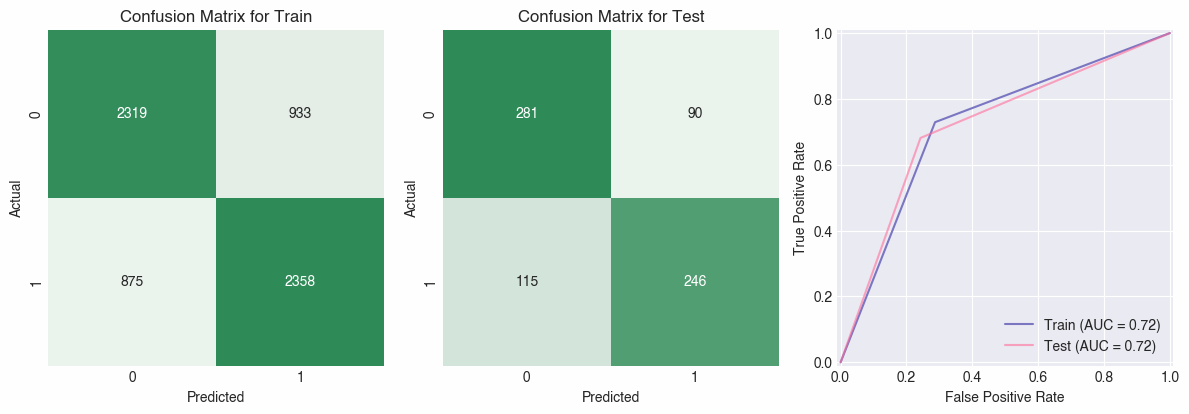

In [ ]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [ ]:
# set file & folder name
folder_name = "voting"
model_name = "voting_xgb_svc_rf.pickle"

# fit or load
finalXGB = em.fit_or_load(
    xgb_pipeline, X_train[feat_xgb], y_train, model_name, folder=folder_name
)

### Evaluate model

### get probabilities from pickle file

In [ ]:
m1=loaded_models['xgb_final_new']
m1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['sp_fix_count',
                                                   'sp_fix_duration_ms_var',
                                                   'sp_len_px_total',
                                                   'sp_saccade_amplitude_px_mean',
                                                   'sp_saccade_amplitude_px_var',
                                                   'sp_distance_to_centre_px_mean',
                                                   'sp_distance_to_centre_px_var',
                                                   'sp_distance_to_sp_mean_px_mean',
                                                   'sp_distance_to_sp_mean_px_var',
                                                   'dg_sal_first...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
m2= loaded_models['RF_final']
m2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('feature_selector',
                                                  FunctionTransformer(func=<function feature_selector at 0x2e059d120>,
                                                                      kw_args={'features_to_keep': ['sp_fix_count',
                                                                                                    'sp_fix_duration_ms_total',
                                                                                                    'sp_fix_duration_ms_mean',
                                                                                                    'sp_fix_duration_ms_var',
                                                                                                    'sp_len_px_total',
                                                                                                    'sp_saccade_amplitude_px_mean',
                                                                                                    'sp_saccade_amplitude_px_var',...
                                                   'sp_distance_to_sp_mean_px_var',
                                                   'dg_sal_first_fixation',
                                                   'dg_sal_mean', 'dg_sal_sum',
                                                   'dg_sal_max',
                                                   'dg_sal_weighted_duration_sum',
                                                   'dg_sal_weighted_duration_mean',
                                                   'dg_sal_KLD', 'dg_sal_NSS',
                                                   'obj_t_abs_on_animate',
                                                   'obj_t_abs_on_background'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=40,
                                        min_samples_split=50, n_estimators=50,
                                        n_jobs=-1, random_state=42))])

In [ ]:
m3= loaded_models['best_svc_resnet']
m3

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['sp_fix_duration_ms_total',
                                                   'sp_fix_duration_ms_mean',
                                                   'sp_fix_duration_ms_var',
                                                   'sam_sal_first_fixation',
                                                   'sam_sal_sum', 'sam_sal_KLD',
                                                   'obj_t_abs_on_background',
                                                   'obj_t_abs_on_animate',
                                                   'obj_n_fix_background',
                                                   'obj_n_fix_inanimate',
                                                   'obj_n_fix_animate'])])),
                ('classifier',
                 SVC(C=0.1, degree=4, kernel='poly', probability=True))])

In [ ]:
with open('../models/logreg_stacking.pickle', 'rb') as f:
    stacking = pickle.load(f)
 

In [ ]:
with open('../models/pred_test.pickle', 'rb') as f:
    pred_test = pickle.load(f)

In [ ]:
with open('../models/proba_test.pickle', 'rb') as f:
    proba_test = pickle.load(f)

30it [00:03,  7.54it/s]


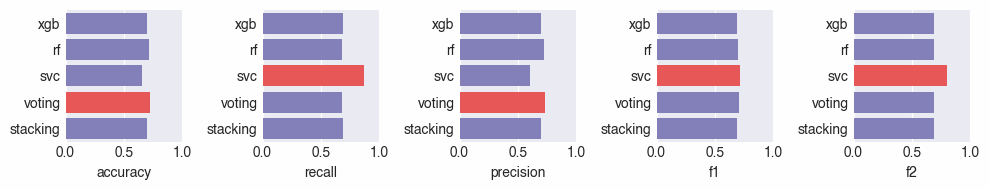

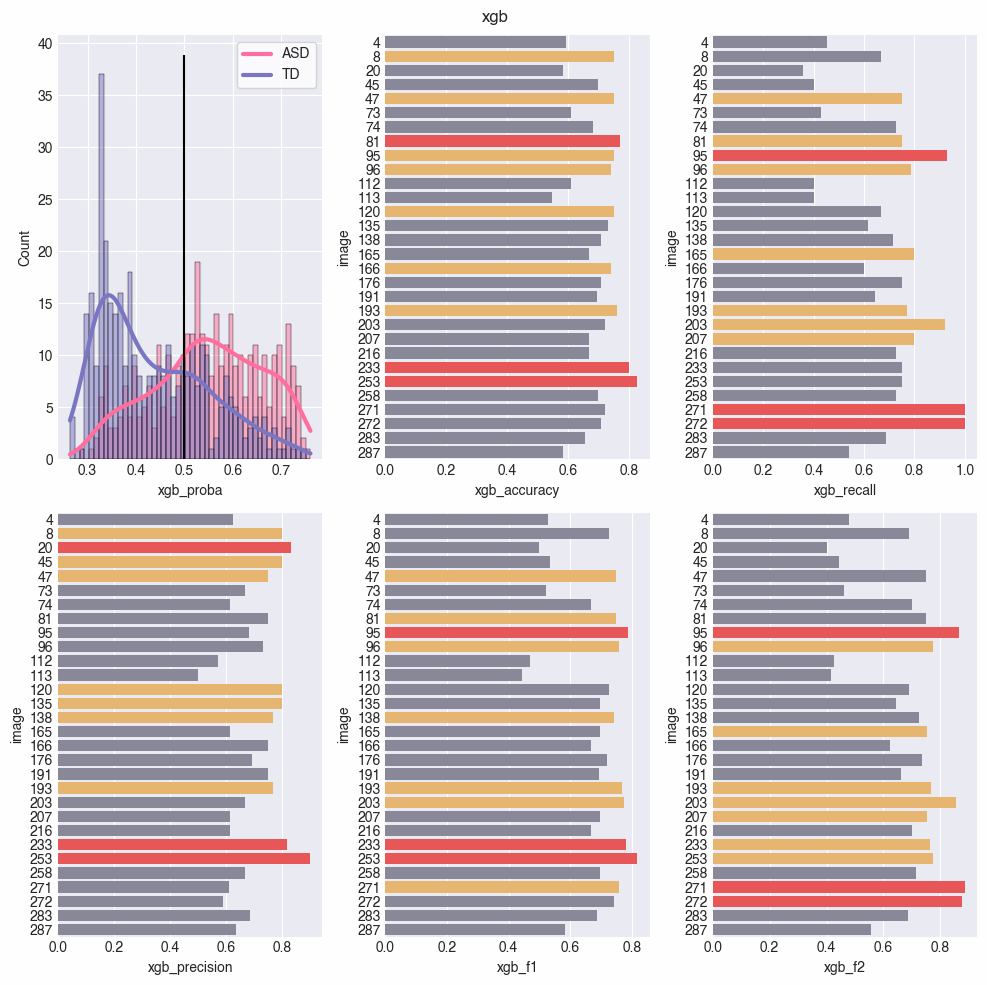

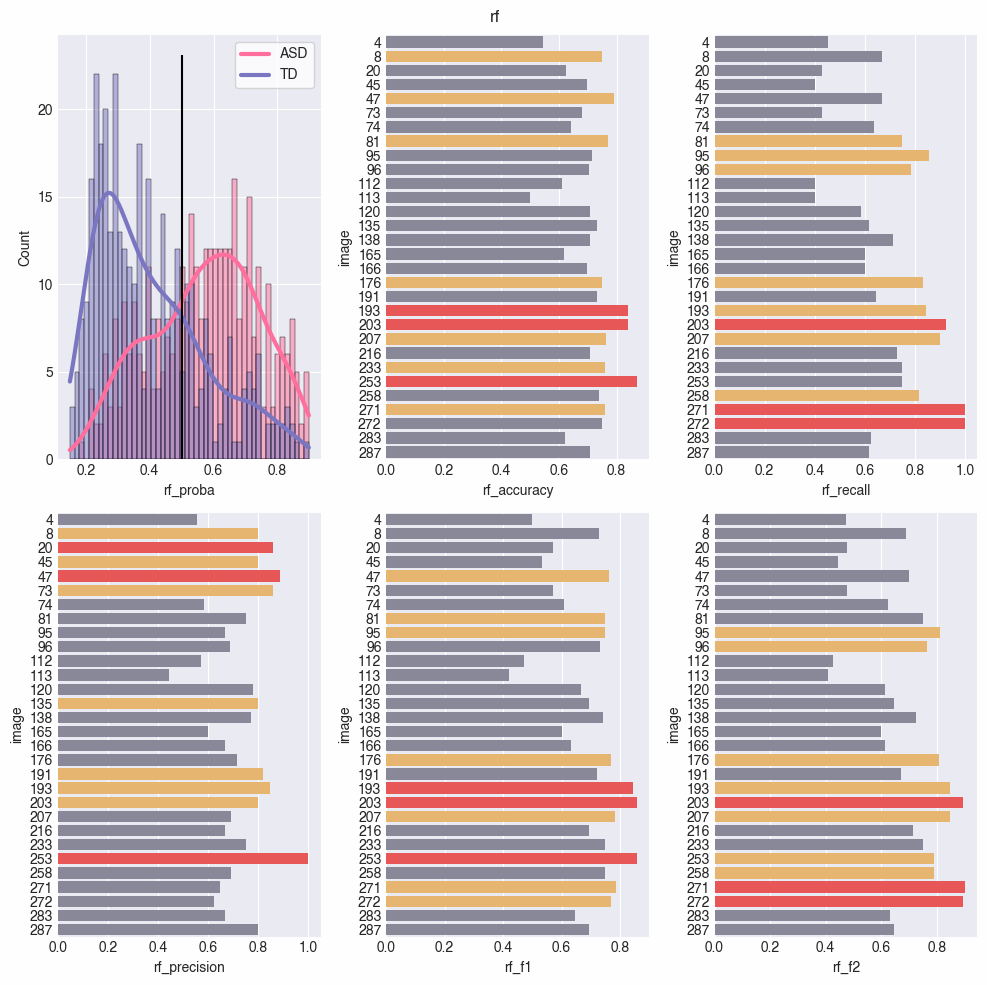

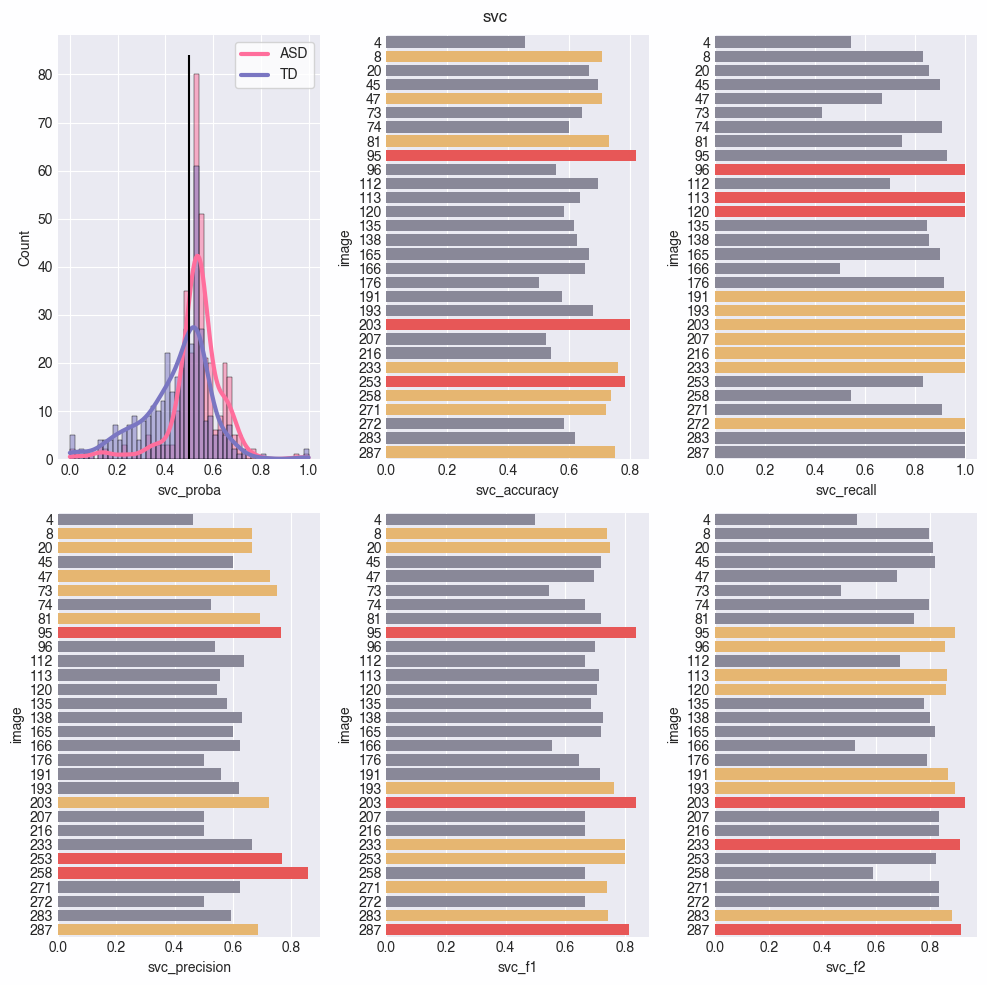

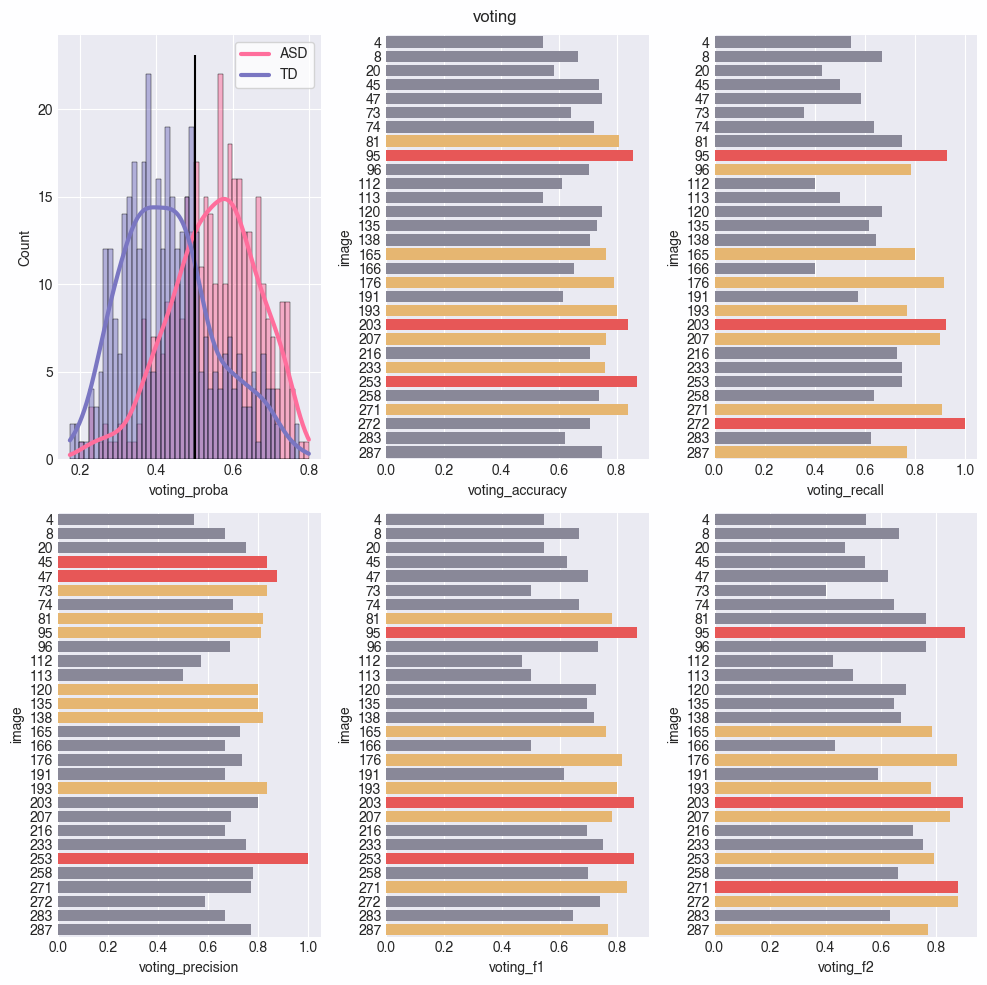

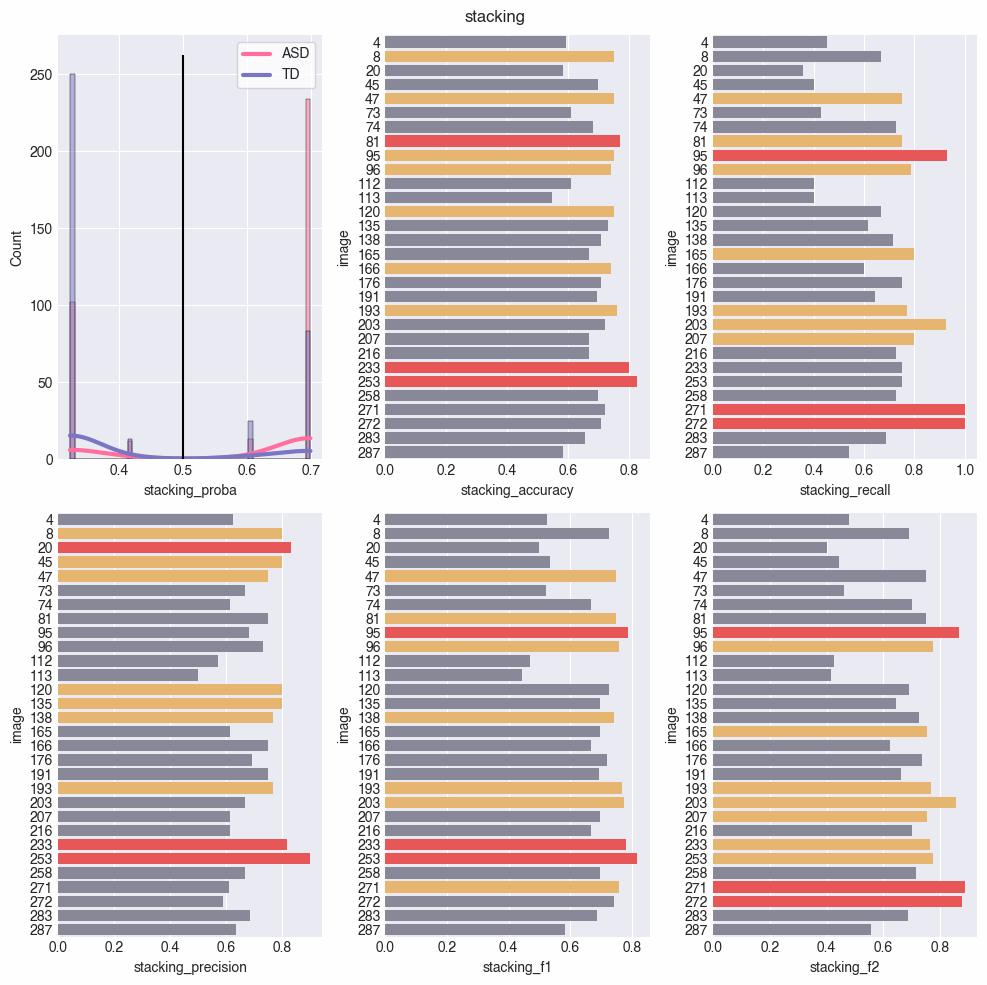

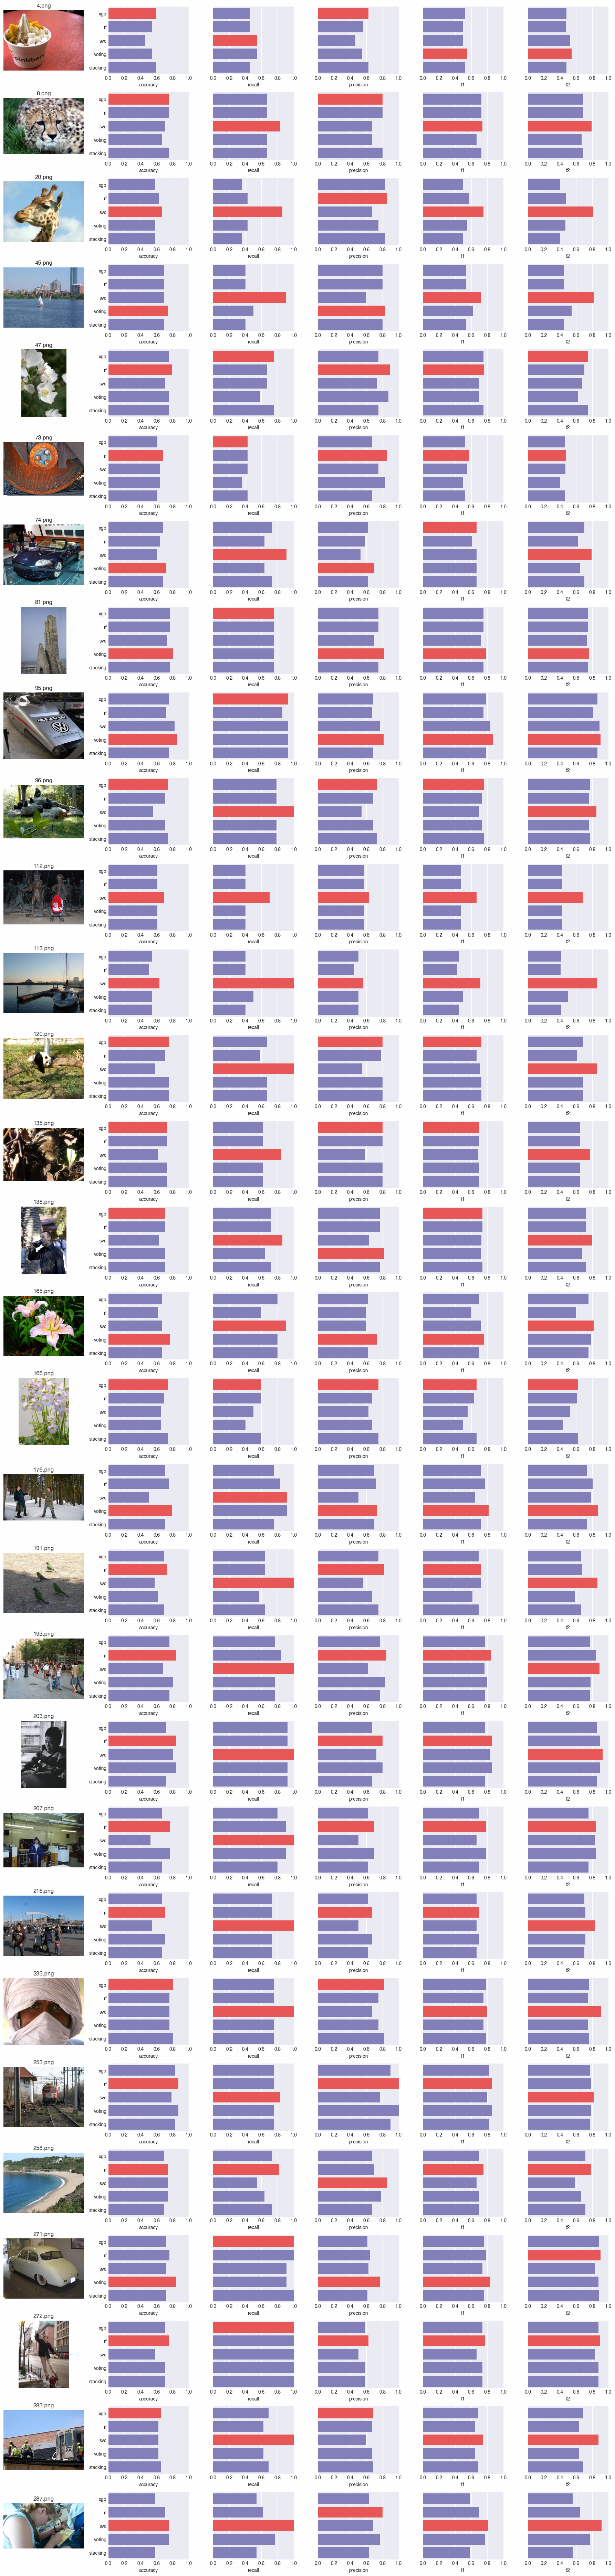

In [ ]:

inp = {
    "xgb": [loaded_models['xgb_final_new'].predict(X_test), loaded_models['xgb_final_new'].predict_proba(X_test)],
    "rf": [loaded_models['RF_final'].predict(X_test), loaded_models['RF_final'].predict_proba(X_test)],
    "svc": [loaded_models['best_svc_resnet'].predict(X_test), loaded_models['best_svc_resnet'].predict_proba(X_test)],
    "voting": [voting_classifier.predict(X_test), voting_classifier.predict_proba(X_test)],
    "stacking":[pred_test, proba_test]
}
em.error_compare_models(inp, y_test)


# Weighted Average 

In [ ]:
model1 = loaded_models['xgb_final_new']
model2 = loaded_models['xgb_final_new']
model3 = loaded_models['xgb_final_new']

model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)

pred1 = model1.predict_proba(X_test)
pred2 = model2.predict_proba(X_test)
pred3 = model3.predict_proba(X_test)

acc1 = accuracy_score(y_test, model1.predict(X_test))
acc2 = accuracy_score(y_test, model2.predict(X_test))
acc3 = accuracy_score(y_test, model3.predict(X_test))

acc_sum = acc1 + acc2 + acc3

weight1 = acc1/acc_sum
weight2 = acc2/acc_sum
weight3 = acc3/acc_sum

finalpred = (pred1*weight1 + pred2*weight2 + pred3*weight3)
finalpred = np.argmax(finalpred.round(0), axis = 1)
(y_test == finalpred).sum() / len(finalpred)

## Voting classifier Calibration

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

In [23]:
# List of paths to the pickle files to load
pickle_files = [
    '../models/xgb_final/xgb_final_new.pickle',
    '../models/RF_final/RF_final.pickle',
    '../models/SVC_final/best_svc_resnet.pickle'

]

# Dictionary to store loaded models
loaded_models = {}

# Load the selected pickle files
for file_path in pickle_files:
    with open(file_path, 'rb') as f:
        model_name = os.path.splitext(os.path.basename(file_path))[0]
        loaded_models[model_name] = pickle.load(f)

In [31]:
from sklearn.exceptions import NotFittedError
# Load the models from pickle files
#loaded_models = {
   # "xgb": loaded_models['xgb_final_new'],
    #"rf": loaded_models['RF_final'],
    #"svc": loaded_models['best_svc_resnet']
#}

# Fit each loaded model with training data
#for model_name, model in loaded_models.items():
    #model.fit(X_train, y_train)

# Calibrate probabilities for each model using training data
calibrated_models = {}
for model_name, model in loaded_models.items():
    calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
    
    try:
        calibrated_model.predict(X_train[:1])  # Attempt to make a prediction
        fitted = True
    except NotFittedError:
        fitted = False
    print(f"{model_name} fitted status: {fitted}")
    #calibrated_model.fit(X_train, y_train)  # Fit with training data
    #calibrated_models[model_name] = calibrated_model
    #print(f"{model_name} fitted status: {calibrated_model.is_fitted}")

# Create the voting classifier with calibrated models
#voting_classifier = VotingClassifier(
    #estimators=[(name, model) for name, model in calibrated_models.items()],
    #voting='soft'
#)

# Fit the voting classifier with training data
#voting_classifier.fit(X_train, y_train)

# Predictions
#predictions = voting_classifier.predict(X_test)

xgb fitted status: False
rf fitted status: False
svc fitted status: False


### Step by Step: Calibration for voting

In [36]:
# define features
feat_xgb = ['sp_fix_count', 'sp_fix_duration_ms_var', 'sp_len_px_total',
       'sp_saccade_amplitude_px_mean', 'sp_saccade_amplitude_px_var',
       'sp_distance_to_centre_px_mean', 'sp_distance_to_centre_px_var',
       'sp_distance_to_sp_mean_px_mean', 'sp_distance_to_sp_mean_px_var',
       'dg_sal_first_fixation', 'dg_sal_sum', 'dg_sal_max', 'dg_sal_weighted_duration_sum',
       'dg_sal_weighted_duration_mean', 'dg_sal_KLD', 'dg_sal_NSS', 'obj_t_abs_on_face',
       'obj_t_rel_on_face', 'obj_t_abs_on_animate', 'obj_t_abs_on_inanimate',
       'obj_t_abs_on_background', 'obj_t_rel_on_animate',
       'obj_t_rel_on_inanimate', 'obj_t_rel_on_background']
       

feat_RF = ['sp_fix_count', 'sp_fix_duration_ms_total', 'sp_fix_duration_ms_mean', 
 'sp_fix_duration_ms_var', 'sp_len_px_total', 'sp_saccade_amplitude_px_mean',
 'sp_saccade_amplitude_px_var', 'sp_distance_to_centre_px_mean',
 'sp_distance_to_centre_px_var', 'sp_distance_to_sp_mean_px_mean',
 'sp_distance_to_sp_mean_px_var', 'dg_sal_first_fixation', 'dg_sal_mean',
 'dg_sal_sum', 'dg_sal_max', 'dg_sal_weighted_duration_sum',
 'dg_sal_weighted_duration_mean', 'dg_sal_KLD', 'dg_sal_NSS',
 'obj_t_abs_on_animate', 'obj_t_abs_on_background']

feat_SVC = ["sp_fix_duration_ms_total","sp_fix_duration_ms_mean","sp_fix_duration_ms_var", "sam_sal_first_fixation","sam_sal_sum","sam_sal_KLD", "obj_t_abs_on_background","obj_t_abs_on_animate", "obj_n_fix_background","obj_n_fix_inanimate","obj_n_fix_animate"]

In [39]:
#Load 3 models pickle files
with open('../models/xgb_final/xgb_final_new.pickle', 'rb') as f:
    xgb_model = pickle.load(f)

with open('../models/RF_final/RF_final.pickle', 'rb') as f:
    rf_model = pickle.load(f)

with open('../models/SVC_final/best_svc_resnet.pickle', 'rb') as f:
    svc_model = pickle.load(f)

In [79]:
#use probability calibrator 

calibrated_xgb = CalibratedClassifierCV(xgb_model, method='isotonic')
calibrated_rf = CalibratedClassifierCV(rf_model, method='isotonic')
calibrated_svc = CalibratedClassifierCV(svc_model, method='isotonic')

In [80]:
#fit calibrated models on training data (use respective feature subsets)

calibrated_xgb.fit(X_train, y_train)
calibrated_rf.fit(X_train, y_train)
calibrated_svc.fit(X_train, y_train)

CalibratedClassifierCV(estimator=Pipeline(steps=[('preprocessor',
                                                  ColumnTransformer(transformers=[('scaler',
                                                                                   StandardScaler(),
                                                                                   ['sp_fix_duration_ms_total',
                                                                                    'sp_fix_duration_ms_mean',
                                                                                    'sp_fix_duration_ms_var',
                                                                                    'sam_sal_first_fixation',
                                                                                    'sam_sal_sum',
                                                                                    'sam_sal_KLD',
                                                                                    'obj_t_abs_on_background',
                                                                                    'obj_t_abs_on_animate',
                                                                                    'obj_n_fix_background',
                                                                                    'obj_n_fix_inanimate',
                                                                                    'obj_n_fix_animate'])])),
                                                 ('classifier',
                                                  SVC(C=0.1, degree=4,
                                                      kernel='poly',
                                                      probability=True))]),
                       method='isotonic')

In [81]:
# Check if estimators are all fitted
from sklearn.exceptions import NotFittedError

def check_if_fitted(model, X_subset):
    try:
        model.predict(X_subset[:1])  # Attempt to make a prediction
        fitted = True
    except NotFittedError:
        fitted = False
    return fitted

# Check if calibrated models are fitted
xgb_fitted = check_if_fitted(calibrated_xgb, X_train)
rf_fitted = check_if_fitted(calibrated_rf, X_train)
svc_fitted = check_if_fitted(calibrated_svc, X_train)

print("Calibrated XGBoost model fitted status:", xgb_fitted)
print("Calibrated Random Forest model fitted status:", rf_fitted)
print("Calibrated Support Vector Classifier model fitted status:", svc_fitted)


Calibrated XGBoost model fitted status: True
Calibrated Random Forest model fitted status: True
Calibrated Support Vector Classifier model fitted status: True


In [82]:
voting_classifier = VotingClassifier(
    estimators=[
        ('calibrated_xgb', calibrated_xgb),
        ('calibrated_rf', calibrated_rf),
        ('calibrated_svc', calibrated_svc)
    ],
    voting='soft'
)

# Fit the voting classifier with training data
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('calibrated_xgb',
                              CalibratedClassifierCV(estimator=Pipeline(steps=[('preprocessor',
                                                                                ColumnTransformer(transformers=[('scaler',
                                                                                                                 MinMaxScaler(),
                                                                                                                 ['sp_fix_count',
                                                                                                                  'sp_fix_duration_ms_var',
                                                                                                                  'sp_len_px_total',
                                                                                                                  'sp_saccade_amplitude_px_mean',
                                                                                                                  'sp_saccade_amplitude_px_var',
                                                                                                                  'sp_distance_to_centre_px_mean',
                                                                                                                  'sp_distance_to_centre_px_var...
                                                                                                                 ['sp_fix_duration_ms_total',
                                                                                                                  'sp_fix_duration_ms_mean',
                                                                                                                  'sp_fix_duration_ms_var',
                                                                                                                  'sam_sal_first_fixation',
                                                                                                                  'sam_sal_sum',
                                                                                                                  'sam_sal_KLD',
                                                                                                                  'obj_t_abs_on_background',
                                                                                                                  'obj_t_abs_on_animate',
                                                                                                                  'obj_n_fix_background',
                                                                                                                  'obj_n_fix_inanimate',
                                                                                                                  'obj_n_fix_animate'])])),
                                                                               ('classifier',
                                                                                SVC(C=0.1,
                                                                                    degree=4,
                                                                                    kernel='poly',
                                                                                    probability=True))]),
                                                     method='isotonic'))],
                 voting='soft')

### Weighted Average

In [87]:
xgb_pred = calibrated_xgb.predict_proba(X_test)
rf_pred = calibrated_rf.predict_proba(X_test)
svc_pred = calibrated_svc.predict_proba(X_test)

f2_1 = fbeta_score(y_test, calibrated_xgb.predict(X_test), beta=2)
f2_2 = fbeta_score(y_test, calibrated_rf.predict(X_test), beta=2)
f2_3 = fbeta_score(y_test, calibrated_svc.predict(X_test), beta=2)

f2_sum = f2_1 + f2_2 + f2_3

weight1 = f2_1/f2_sum
weight2 = f2_2/f2_sum
weight3 = f2_3/f2_sum

finalproba = (xgb_pred*weight1 + rf_pred*weight2 + svc_pred*weight3)
finalpred = np.argmax(finalproba.round(0), axis = 1)
(y_test == finalpred).sum() / len(finalpred)

0.7213114754098361

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.712     0.755     0.733       371
           1      0.732     0.687     0.709       361

    accuracy                          0.721       732
   macro avg      0.722     0.721     0.721       732
weighted avg      0.722     0.721     0.721       732

f(0.5)-score: 0.722
f(2.0)-score: 0.695



TypeError: 'Axes' object is not subscriptable

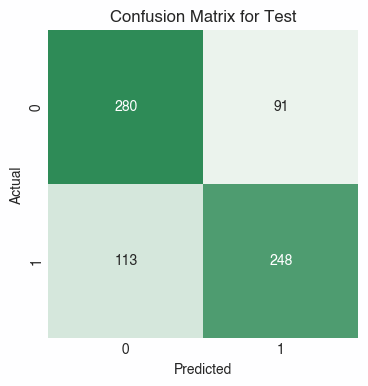

In [89]:
em.report(y_test=y_test, y_test_pred=finalpred)

30it [00:04,  6.37it/s]


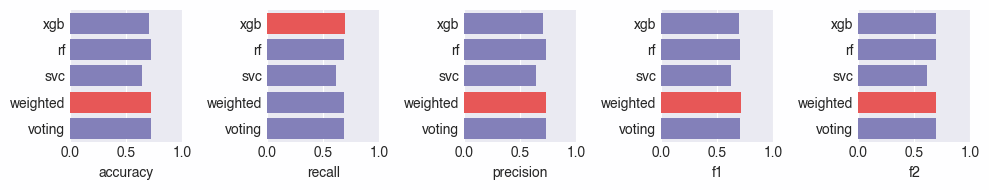

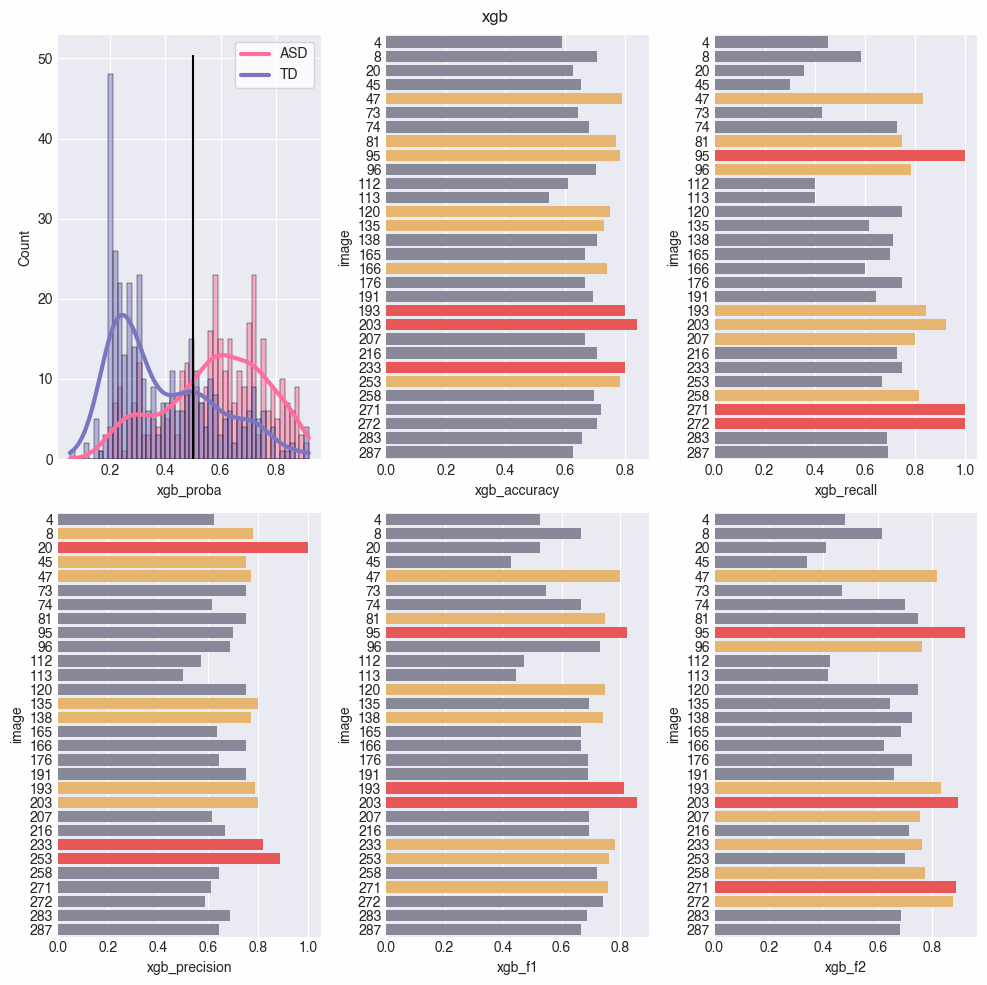

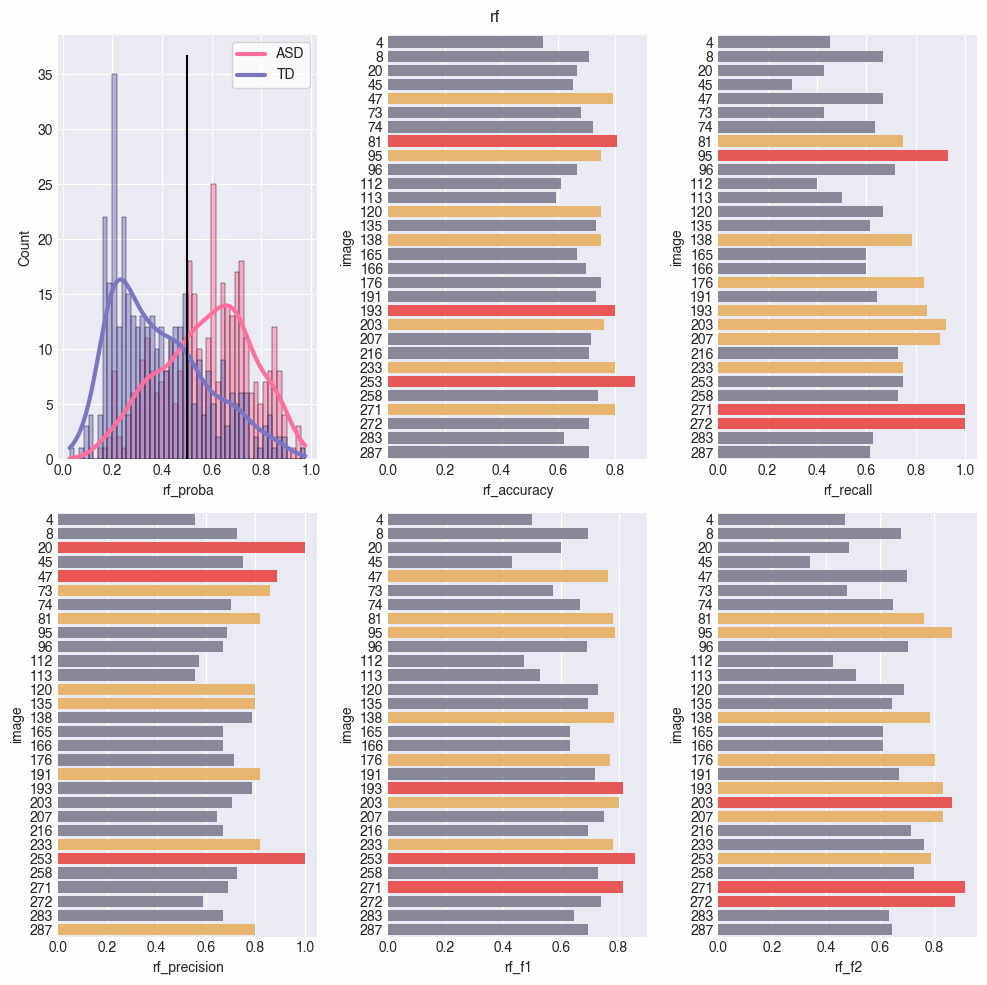

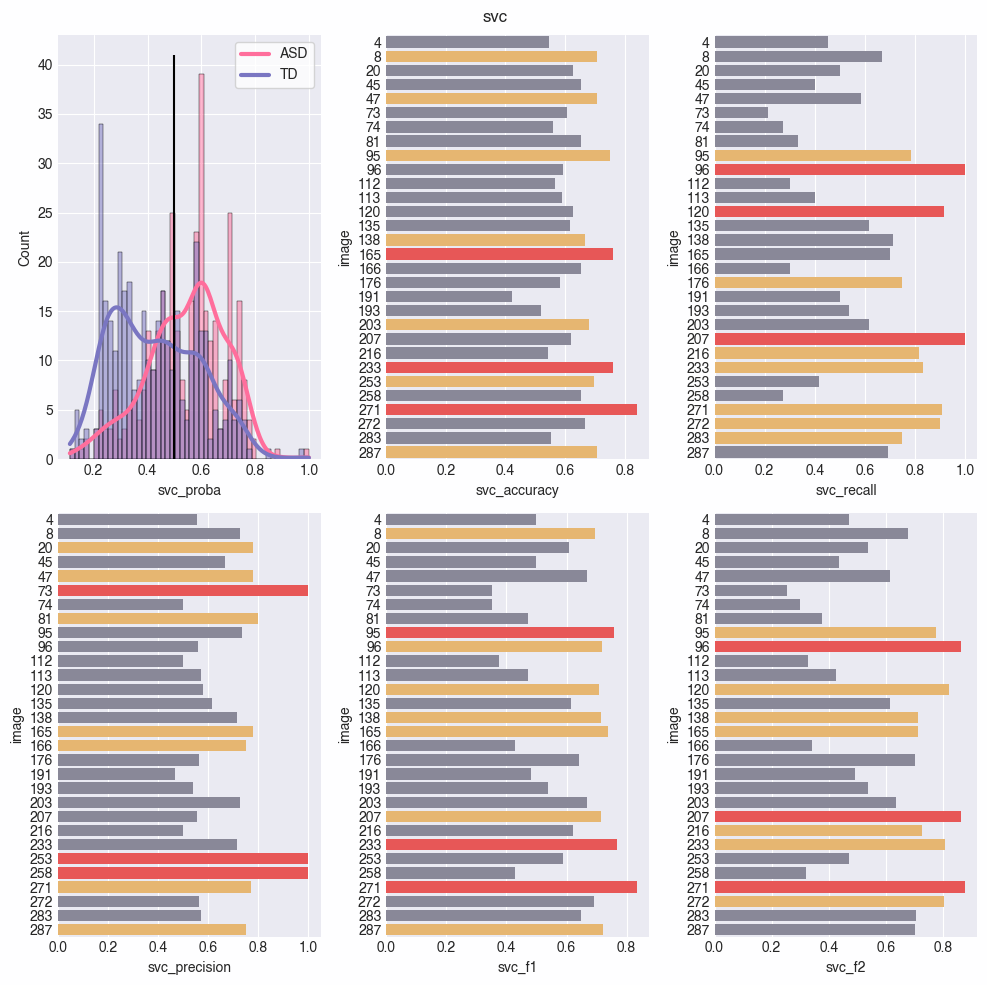

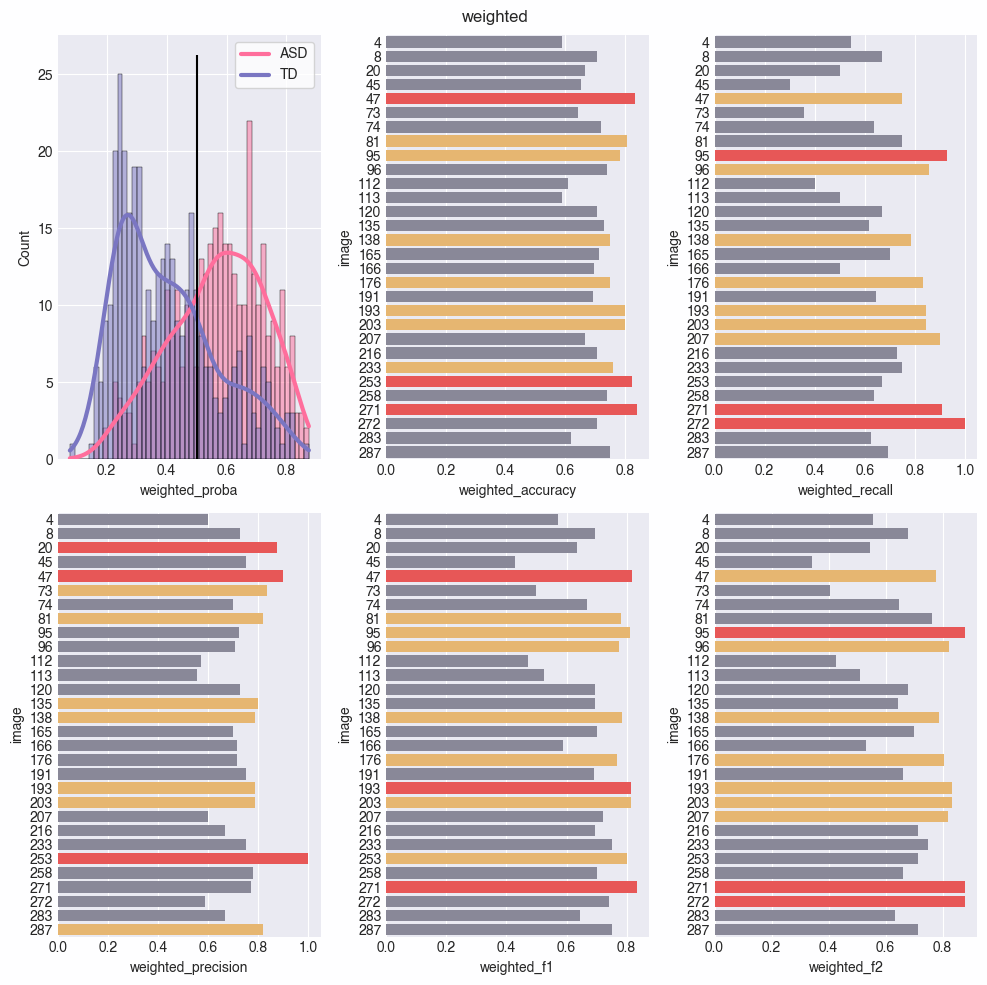

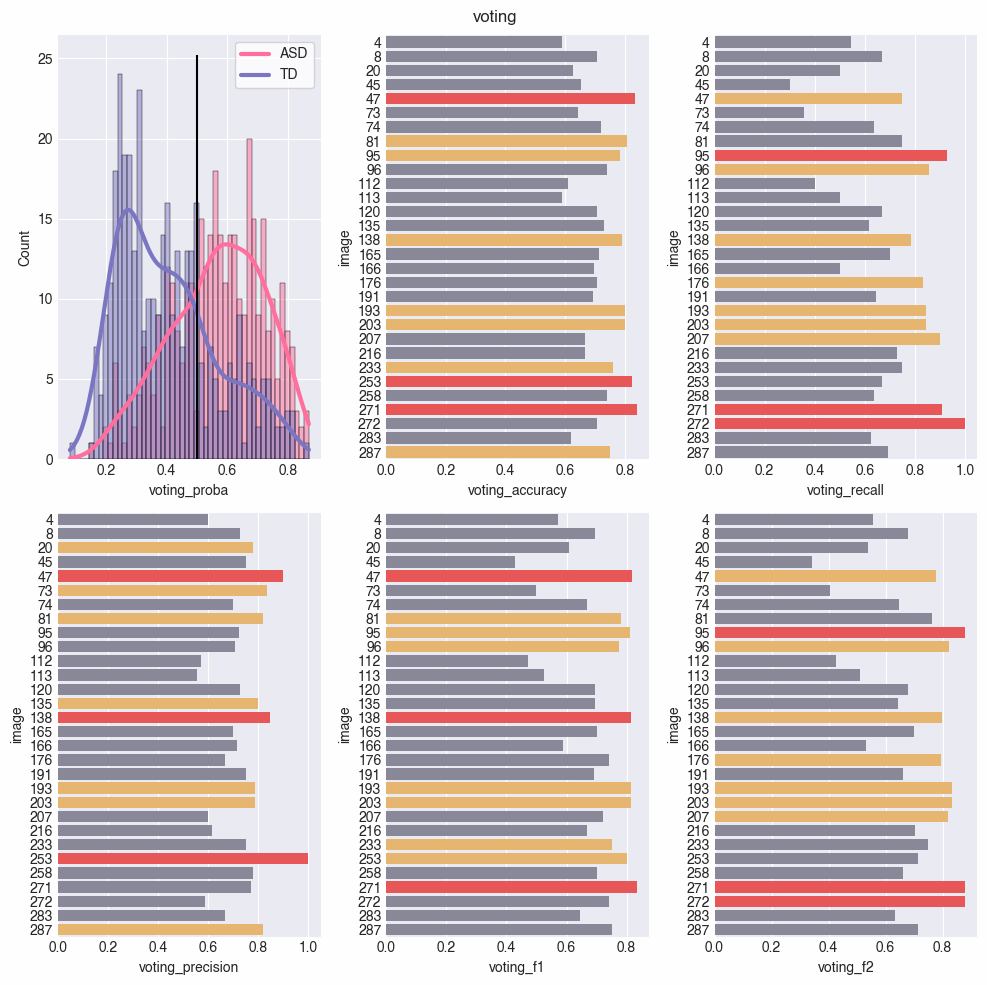

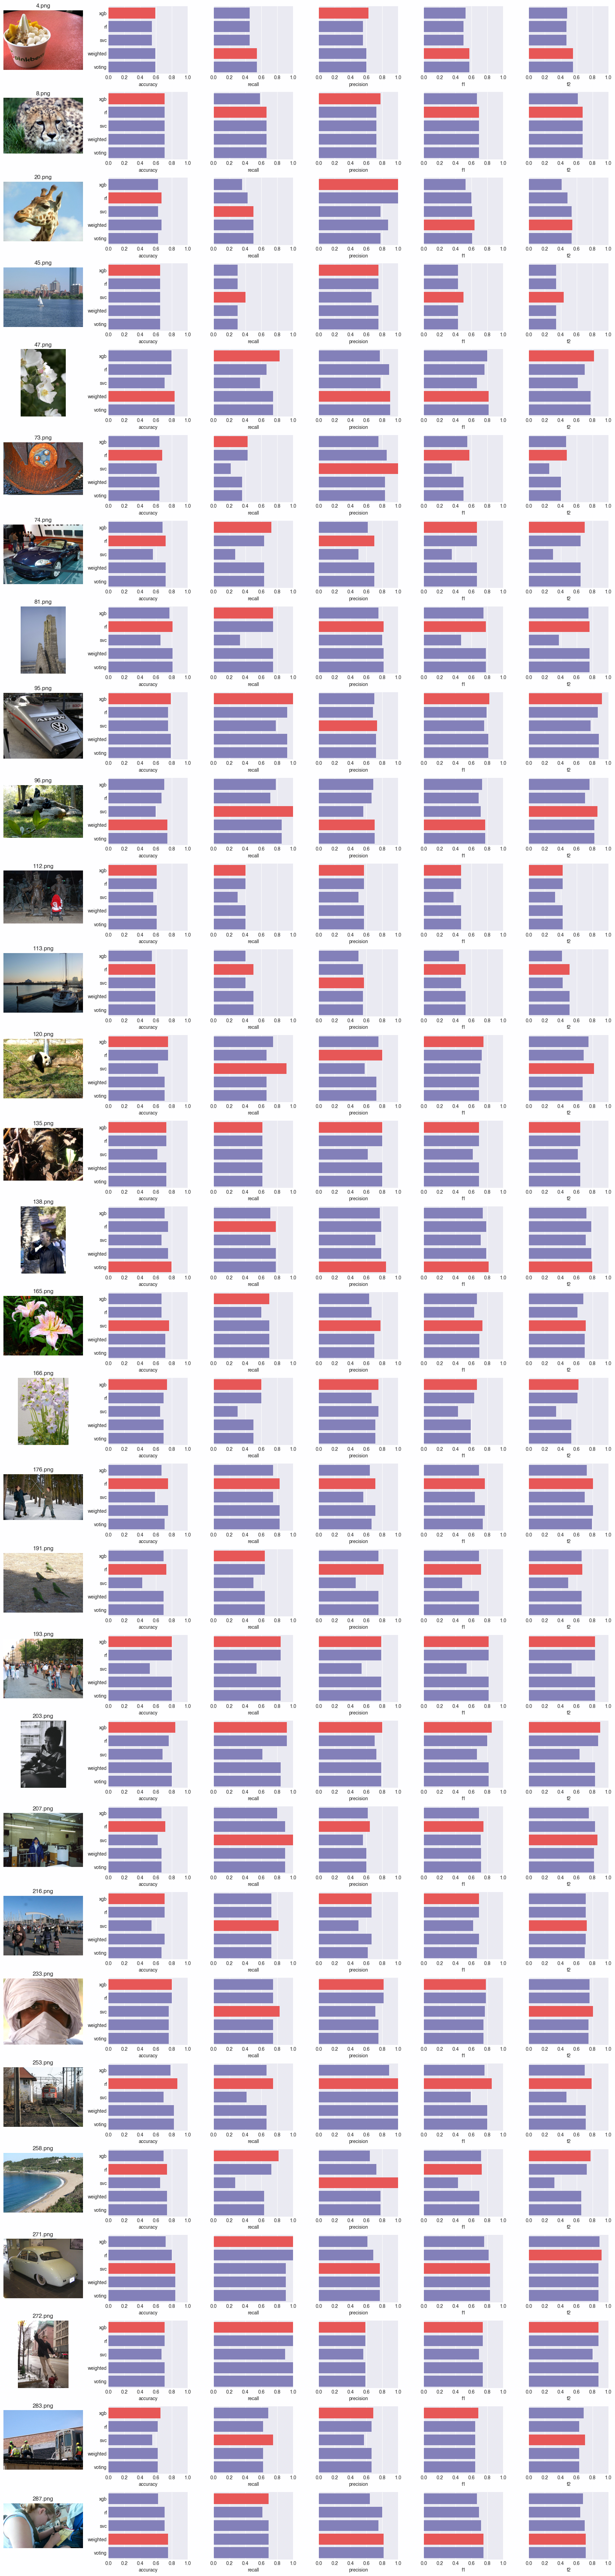

In [90]:

inp = {
    "xgb": [calibrated_xgb.predict(X_test), calibrated_xgb.predict_proba(X_test)],
    "rf": [calibrated_rf.predict(X_test), calibrated_rf.predict_proba(X_test)],
    "svc": [calibrated_svc.predict(X_test), calibrated_svc.predict_proba(X_test)],
    "weighted": [finalpred, finalproba],
    "voting":[voting_classifier.predict(X_test),voting_classifier.predict_proba(X_test)] 
}
em.error_compare_models(inp, y_test)

### Get best params from pickle file

In [ ]:
# List of paths to the pickle files you want to load
pickle_files = [
    '../models/xgb_final/xgb_5.pickle',
    '../models/RF_final/RF_final.pickle',
    '../models/SVC_final/best_svc_resnet.pkl'
]

# Dictionary to store loaded models
loaded_models = {}

# Load the selected pickle files
for file_path in pickle_files:
    with open(file_path, 'rb') as f:
        file_name = os.path.basename(file_path)
        model_name = os.path.splitext(file_name)[0]
        loaded_models[model_name] = pickle.load(f)

In [ ]:
# List of paths to the pickle files 
pickle_files = [
    '../models/xgb_final/xgb_5.pickle',
    '../models/RF_final/RF_final.pickle',
    '../models/SVC_final/best_svc_resnet.pkl'
]

# Dictionary to store loaded models
loaded_models = {}

# Load the selected pickle files
for file_path in pickle_files:
    with open(file_path, 'rb') as f:
        file_name = os.path.basename(file_path)
        model_name = os.path.splitext(file_name)[0]
        loaded_models[model_name] = pickle.load(f)

# Check if the model has best parameters
if hasattr(loaded_models[best_svc_resnet.pkl], 'best_params_'):
    best_params = loaded_models[best_svc_resnet.pkl].best_params_
    print("Best Parameters:", best_params)
else:
    print("Model does not have best parameters.")

### Load models from pickle files

In [ ]:
# List of paths to the pickle files you want to load
pickle_files = [
    '../models/xgb_final/xgb_5.pickle',
    '../models/RF_final/RF_final.pickle',
    '../models/SVC_final/best_svc_resnet.pkl'
]

# Dictionary to store loaded models
loaded_models = {}

# Load the selected pickle files
for file_path in pickle_files:
    with open(file_path, 'rb') as f:
        file_name = os.path.basename(file_path)
        model_name = os.path.splitext(file_name)[0]
        loaded_models[model_name] = pickle.load(f)

xgb_pred = xgb_5.predict_proba(X_test[feat_xgb])
rf_pred= RF_final.predict_proba(X_test[feat_RF])
svc_pred = best_svc_resnet.predict_proba(X_test[feat_SVC])

finalpred = (pred1 + pred2 + pred3) / 3
finalpred = np.argmax(finalpred.round(0), axis = 1)
(y_test == finalpred).sum() / len(finalpred)


### Averaging the predictions

In [ ]:
# List of paths to the pickle files you want to load
pickle_files = [
    '../models/xgb_final/xgb_5.pickle',
    '../models/RF_final/RF_final.pickle',
    '../models/SVC_final/best_svc_resnet.pkl'
]

# Dictionary to store loaded models
loaded_models = {}

# Load the selected pickle files
for file_path in pickle_files:
    with open(file_path, 'rb') as f:
        model_name = os.path.splitext(os.path.basename(file_path))[0]
        loaded_models[model_name] = pickle.load(f)

#fit each model on selected features
loaded_models['xgb_5'].fit(X_train[feat_xgb],y_train[feat_xgb])
loaded_models['RF_final'].fit(X_train[feat_RF],y_train[feat_RF])
loaded_models['best_svc_resnet'].fit(X_train[feat_SVC],y_train[feat_SVC])


# Make predictions for each model
xgb_pred = loaded_models['xgb_5'].predict_proba(X_test[feat_xgb])
rf_pred = loaded_models['RF_final'].predict_proba(X_test[feat_RF])
svc_pred = loaded_models['best_svc_resnet'].predict_proba(X_test[feat_SVC])

# Average the predictions
final_pred = (xgb_pred + rf_pred + svc_pred) / 3

# Convert probabilities to class labels
final_pred_labels = np.argmax(final_pred.round(0), axis=1)

In [ ]:
xgb_pred = xgb_5.predict_proba(X_test[feat_xgb])
rf_pred= RF_final.predict_proba(X_test[feat_RF])
svc_pred = best_svc_resnet.predict_proba(X_test[feat_SVC])

finalpred = (pred1 + pred2 + pred3) / 3
finalpred = np.argmax(finalpred.round(0), axis = 1)
(y_test == finalpred).sum() / len(finalpred)

### Use the voting classifier to predict 

In [ ]:
# Select common features
common_features = list(set(feat_xgb) & set(feat_RF) & set(feat_SVC))

# Filter the DataFrame to include only the common features
df_filtered = df[common_features]

# Create the voting classifier
voting_classifier = VotingClassifier(
    estimators=list(loaded_models.items()),
    voting='soft'  # 'soft' if models provide probabilities

)

# Fit the voting classifier
voting_classifier.fit(X_train, y_train)

# Predictions
predictions = voting_classifier.predict(X_test)

In [ ]:
from sklearn.ensemble import VotingClassifier

model1 = LogisticRegression(random_state = RSEED)
model2 =  KNeighborsClassifier()
model3 = DecisionTreeClassifier(random_state = RSEED)

model = VotingClassifier(estimators = [('lr', model1), ('knn', model2), ('dt', model3)], voting = 'hard')
model.fit(X_train,y_train)
model.score(X_test,y_test)